In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [21]:
train_dir = './data/train'
test_dir = './data/test' 

In [22]:
def visualize_images(data_dir):
    classes = os.listdir(data_dir)
    plt.figure(figsize=(15, 10))
    for i, emotion_class in enumerate(classes[:9]):  
        class_path = os.path.join(data_dir, emotion_class)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            if image_files:
                img_path = os.path.join(class_path, random.choice(image_files))
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                plt.subplot(3, 3, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(emotion_class)
                plt.axis('off')
    plt.tight_layout()
    plt.show()

Visualizing sample images from the training dataset...


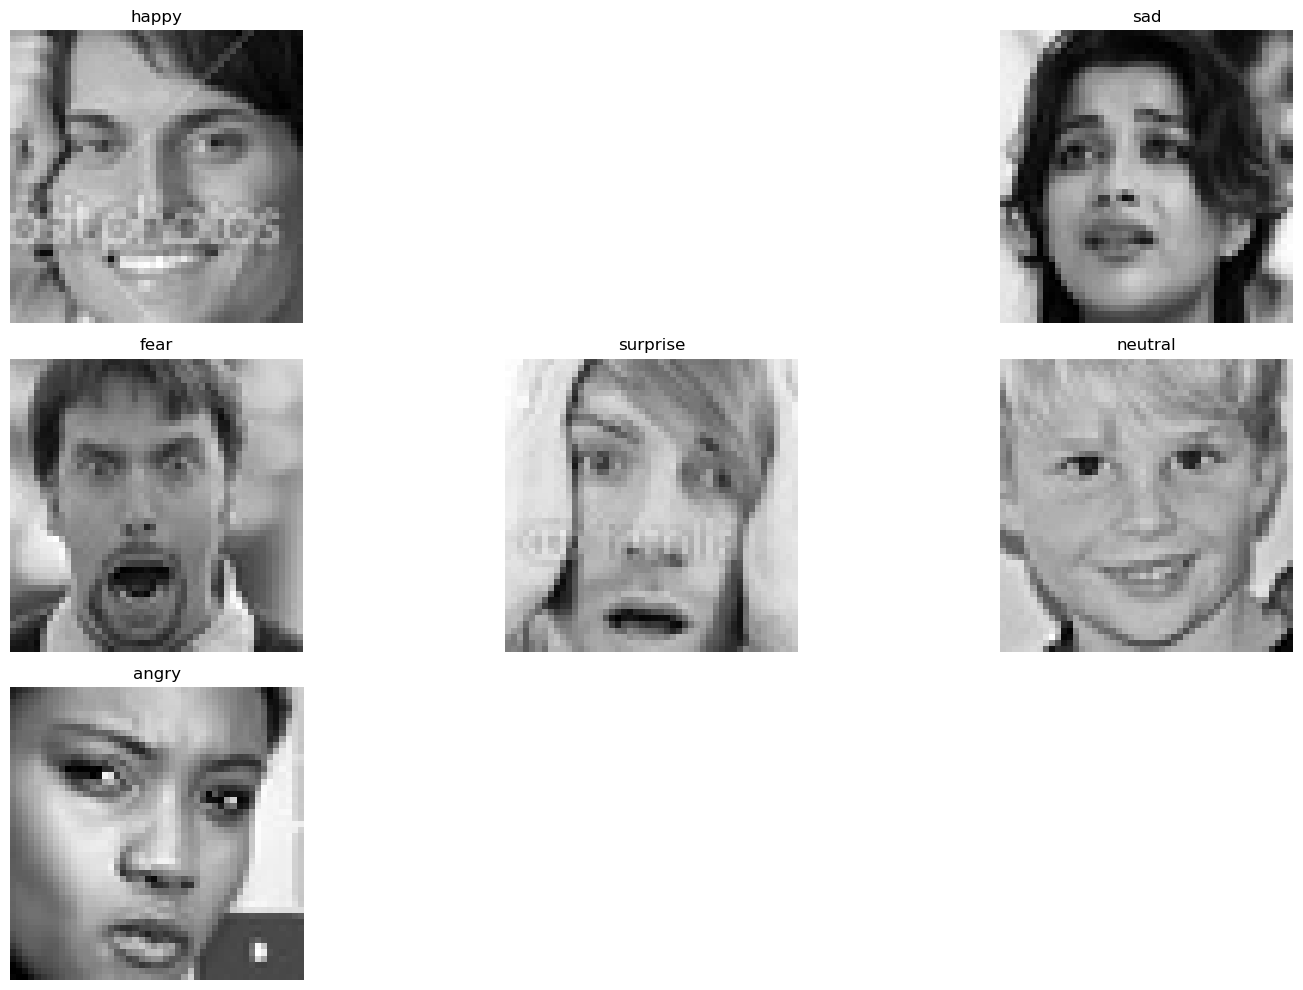

In [23]:
print("Visualizing sample images from the training dataset...")
visualize_images(train_dir)

In [24]:
def count_images(data_dir):
    class_counts = {}
    classes = os.listdir(data_dir) 
    for emotion_class in classes:
        class_path = os.path.join(data_dir, emotion_class)
        if os.path.isdir(class_path):  
            class_counts[emotion_class] = len(os.listdir(class_path))
    
    return class_counts

In [25]:
train_class_counts = count_images(train_dir)

In [26]:
print("Number of images in each class (Training Data):")
for emotion, count in train_class_counts.items():
    print(f"{emotion}: {count} images")

Number of images in each class (Training Data):
happy: 5000 images
sad: 4830 images
fear: 4097 images
surprise: 3171 images
neutral: 4965 images
angry: 3995 images


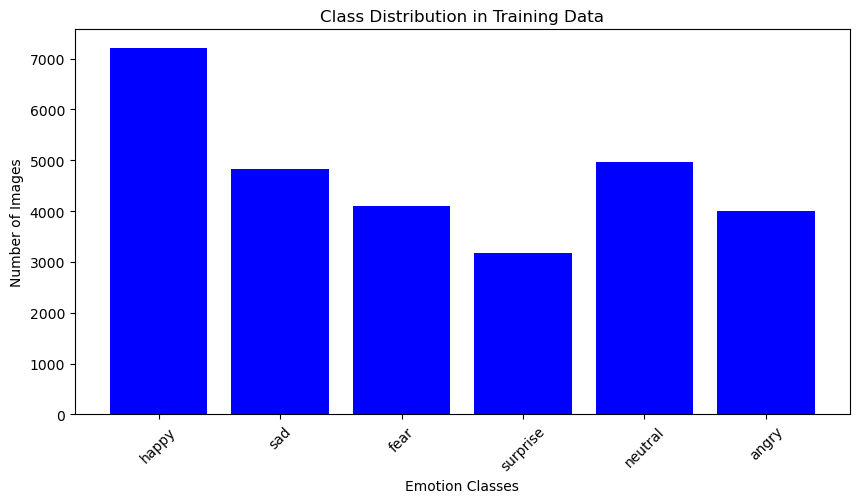

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='blue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [9]:
happy_dir = './data/train/happy'

In [10]:
import random

happy_images = os.listdir(happy_dir)
target_count = 5000  
num_to_remove = len(happy_images) - target_count
images_to_remove = random.sample(happy_images, num_to_remove)

for image in images_to_remove:
    os.remove(os.path.join(happy_dir, image))

print(f"Removed {num_to_remove} images from the 'Happy' class.")

Removed 2215 images from the 'Happy' class.


Updated number of images in each class (Training Data):
happy: 5000 images
sad: 4830 images
fear: 4097 images
surprise: 3171 images
neutral: 4965 images
angry: 3995 images


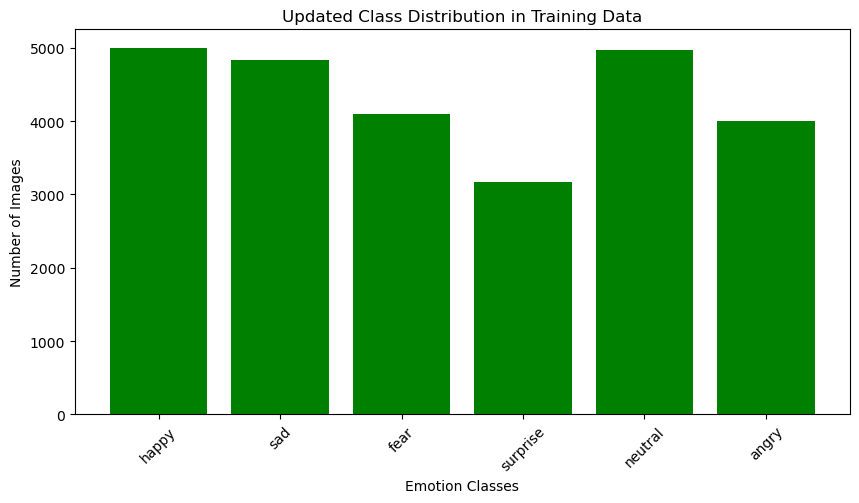

In [11]:
train_class_counts = count_images(train_dir)

print("Updated number of images in each class (Training Data):")
for emotion, count in train_class_counts.items():
    print(f"{emotion}: {count} images")

plt.figure(figsize=(10, 5))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='green')
plt.title("Updated Class Distribution in Training Data")
plt.xlabel("Emotion Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=30, 
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    zoom_range=0.2,
    horizontal_flip=True 
)

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128), 
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical'
)



Found 26058 images belonging to 6 classes.


In [29]:

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 7067 images belonging to 6 classes.


In [30]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  
])


In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,781,062 (10.61 MB)

 Trainable params: 2,781,062 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True  
)

In [20]:
history_cnn = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50, 
    callbacks=[early_stopping]  #
)


Epoch 1/50


/Users/saivamshichallamalla/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


408/408 ━━━━━━━━━━━━━━━━━━━━ 130s 318ms/step - accuracy: 0.1947 - loss: 1.7780 - val_accuracy: 0.2332 - val_loss: 1.7419
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 134s 330ms/step - accuracy: 0.2123 - loss: 1.7567 - val_accuracy: 0.2541 - val_loss: 1.7227
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 173s 423ms/step - accuracy: 0.2519 - loss: 1.7288 - val_accuracy: 0.3267 - val_loss: 1.6221
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 164s 401ms/step - accuracy: 0.2892 - loss: 1.6641 - val_accuracy: 0.3581 - val_loss: 1.5657
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 173s 425ms/step - accuracy: 0.3188 - loss: 1.6259 - val_accuracy: 0.4132 - val_loss: 1.4970
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 171s 418ms/step - accuracy: 0.3492 - loss: 1.5855 - val_accuracy: 0.4449 - val_loss: 1.4283
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 171s 419ms/step - accuracy: 0.3670 - loss: 1.5544 - val_accuracy: 0.4500 - val_loss: 1.3808
Epoch 8/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 178s 435ms/step - accuracy: 0.3756 - loss: 1.51

In [21]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")

x_batch shape: (64, 128, 128, 1), y_batch shape: (64, 6)


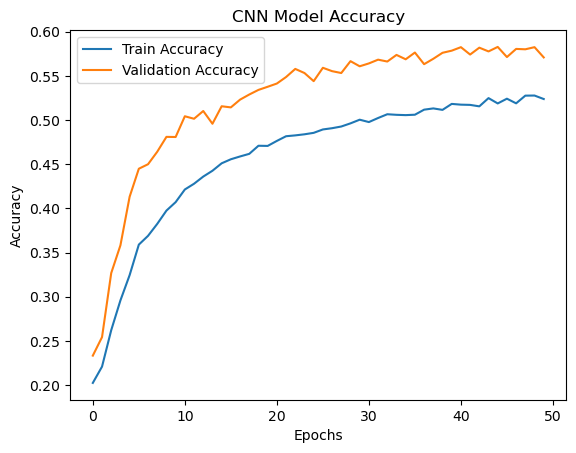

In [25]:
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

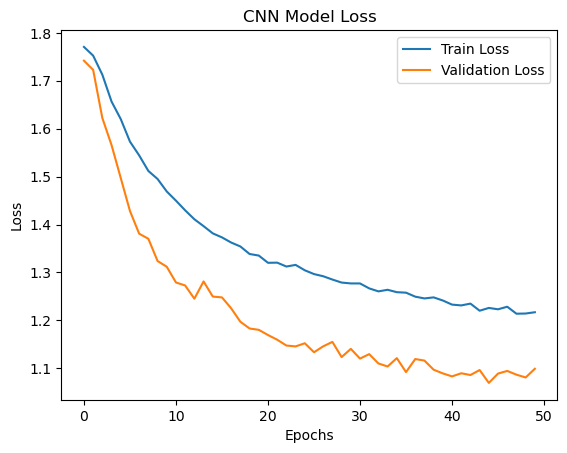

In [26]:
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [27]:
test_preds = model.predict(test_generator)
test_preds = np.argmax(test_preds, axis=1)
test_labels = test_generator.classes

conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)


111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
Confusion Matrix:
[[ 427   47   53  167  228   36]
 [ 140  134   74  197  323  156]
 [  41   23 1436  140   90   44]
 [  56   30   75  814  251    7]
 [ 104   39   80  325  670   29]
 [  19   40   50   55   29  638]]


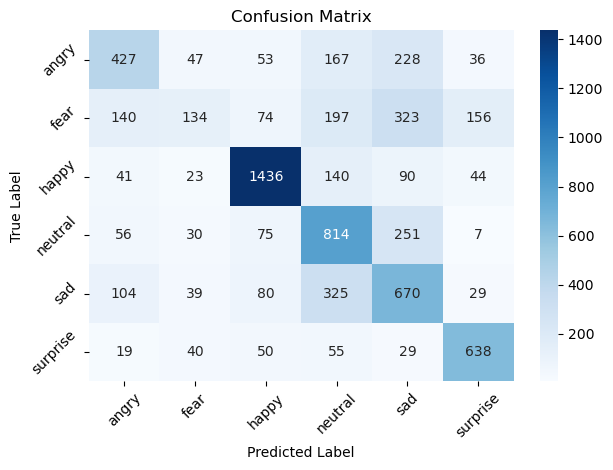

In [28]:
class_names = list(test_generator.class_indices.keys())
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       angry       0.54      0.45      0.49       958
        fear       0.43      0.13      0.20      1024
       happy       0.81      0.81      0.81      1774
     neutral       0.48      0.66      0.56      1233
         sad       0.42      0.54      0.47      1247
    surprise       0.70      0.77      0.73       831

    accuracy                           0.58      7067
   macro avg       0.56      0.56      0.54      7067
weighted avg       0.58      0.58      0.57      7067



In [30]:
model.save('emotion_model_cnn.h5')

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D

input_shape = (128,128, 1)

MobileNetV2_model = Sequential([
    Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape), 
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  
])


/Users/saivamshichallamalla/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:


MobileNetV2_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [9]:
MobileNetV2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,756 (9.24 MB)

 Trainable params: 2,388,644 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [37]:

history = MobileNetV2_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=60,  
    callbacks=[early_stopping]
)



Epoch 1/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 346s 831ms/step - accuracy: 0.2462 - loss: 1.8794 - val_accuracy: 0.2070 - val_loss: 2.0391
Epoch 2/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 333s 816ms/step - accuracy: 0.4018 - loss: 1.4965 - val_accuracy: 0.2785 - val_loss: 1.7584
Epoch 3/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 336s 822ms/step - accuracy: 0.4663 - loss: 1.3637 - val_accuracy: 0.3862 - val_loss: 1.5551
Epoch 4/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 341s 835ms/step - accuracy: 0.5028 - loss: 1.2755 - val_accuracy: 0.4565 - val_loss: 1.3783
Epoch 5/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 351s 861ms/step - accuracy: 0.5322 - loss: 1.2180 - val_accuracy: 0.5077 - val_loss: 1.2693
Epoch 6/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 346s 847ms/step - accuracy: 0.5533 - loss: 1.1640 - val_accuracy: 0.5551 - val_loss: 1.1503
Epoch 7/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 346s 847ms/step - accuracy: 0.5650 - loss: 1.1287 - val_accuracy: 0.5693 - val_loss: 1.1250
Epoch 8/60
408/408 ━━━━━━━━━━━━━━━━━━━━ 346s 847ms/step - accuracy: 0.5793 -

Text(0.5, 1.0, 'Model Accuracy')

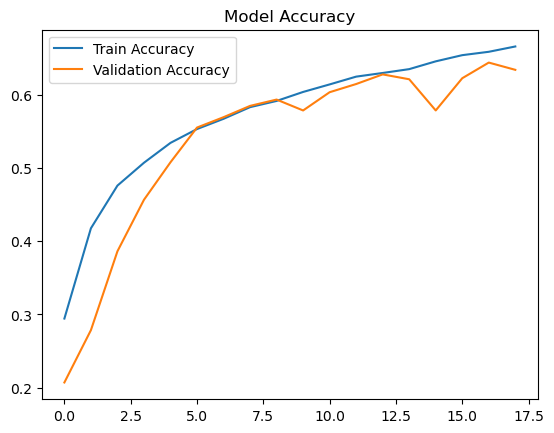

In [38]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')



Text(0.5, 1.0, 'Model Loss')

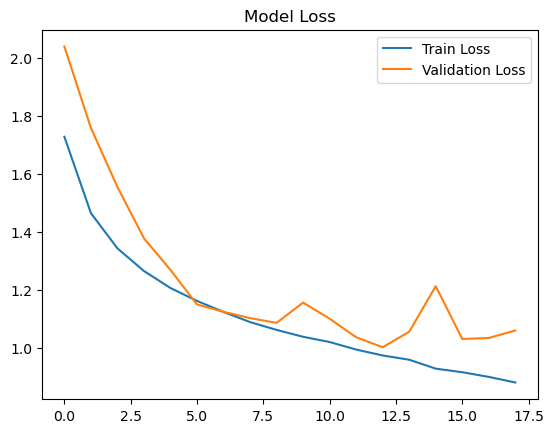

In [39]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

In [40]:
test_preds = model.predict(test_generator)
test_preds = np.argmax(test_preds, axis=1)
test_labels = test_generator.classes

conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)


111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Confusion Matrix:
[[ 427   47   53  167  228   36]
 [ 140  134   74  197  323  156]
 [  41   23 1436  140   90   44]
 [  56   30   75  814  251    7]
 [ 104   39   80  325  670   29]
 [  19   40   50   55   29  638]]


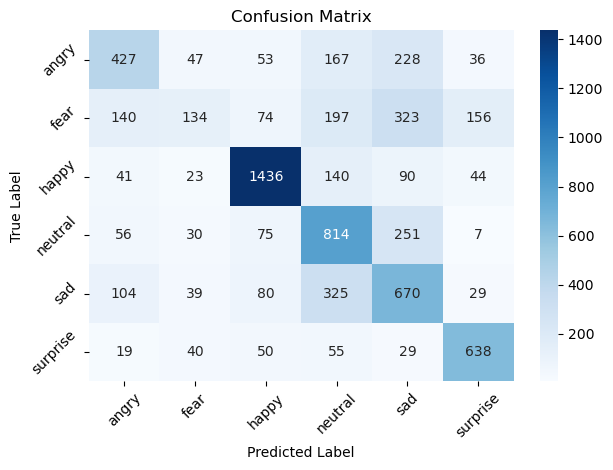

In [41]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
MobileNetV2_model.save('emotion_model_MobileNetV2.h5')

In [43]:
test_preds = MobileNetV2_model.predict(test_generator)
test_preds_labels = np.argmax(test_preds, axis=1)
true_labels = test_generator.classes


class_names = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_labels, test_preds_labels, target_names=class_names))
conf_matrix = confusion_matrix(true_labels, test_preds_labels)

111/111 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.35      0.48       958
        fear       0.46      0.37      0.41      1024
       happy       0.81      0.88      0.84      1774
     neutral       0.54      0.62      0.58      1233
         sad       0.48      0.61      0.54      1247
    surprise       0.72      0.76      0.74       831

    accuracy                           0.63      7067
   macro avg       0.63      0.60      0.60      7067
weighted avg       0.64      0.63      0.62      7067



## EfficientNet Model


In [44]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D

input_shape = (128, 128, 1)

efficientnet_model = Sequential([
    Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    GlobalAveragePooling2D(), 
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  
])






/Users/saivamshichallamalla/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:

efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
efficientnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,343 (16.08 MB)

 Trainable params: 4,172,320 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)


In [22]:
history = efficientnet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30, 
    callbacks=[early_stopping]  
)

Epoch 1/30


/Users/saivamshichallamalla/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


408/408 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.2963 - loss: 1.6776 - val_accuracy: 0.1745 - val_loss: 1.9370
Epoch 2/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.4927 - loss: 1.3021 - val_accuracy: 0.1381 - val_loss: 1.9812
Epoch 3/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - accuracy: 0.5492 - loss: 1.1804 - val_accuracy: 0.1821 - val_loss: 3.5854
Epoch 4/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.5719 - loss: 1.1304 - val_accuracy: 0.1330 - val_loss: 2.1888
Epoch 5/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.5869 - loss: 1.0883 - val_accuracy: 0.4082 - val_loss: 1.4909
Epoch 6/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.6039 - loss: 1.0471 - val_accuracy: 0.1930 - val_loss: 2.0878
Epoch 7/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.6204 - loss: 1.0187 - val_accuracy: 0.1527 - val_loss: 2.0248
Epoch 8/30
408/408 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.6248 - loss: 0.9921 - val_accuracy: 0.390

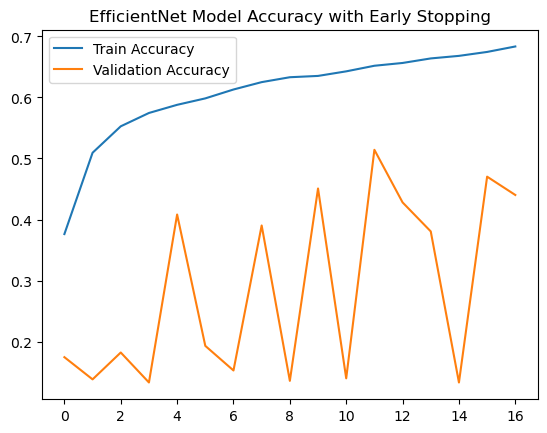

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('EfficientNet Model Accuracy with Early Stopping')
plt.show()

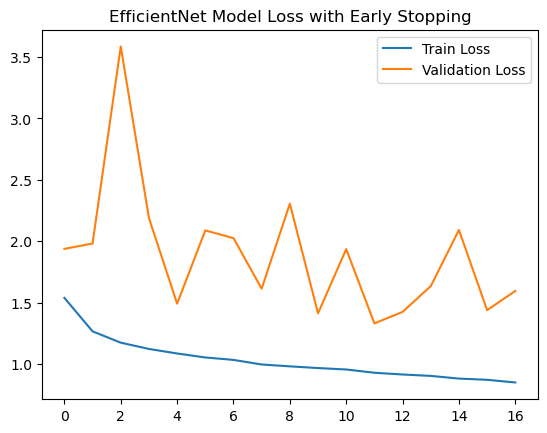

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('EfficientNet Model Loss with Early Stopping')
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step


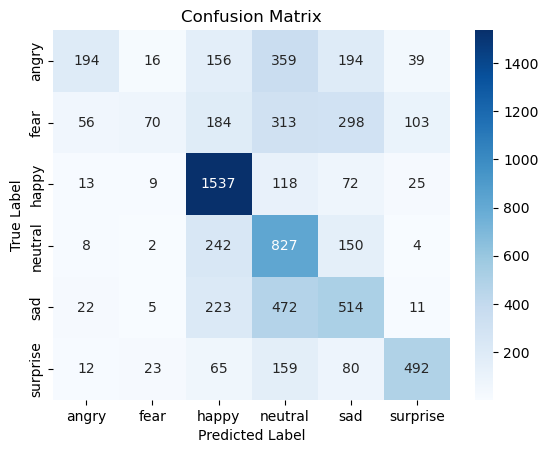

In [26]:
test_preds = efficientnet_model.predict(test_generator)
test_preds = np.argmax(test_preds, axis=1)
test_labels = test_generator.classes

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, test_preds)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.20      0.31       958
        fear       0.56      0.07      0.12      1024
       happy       0.64      0.87      0.74      1774
     neutral       0.37      0.67      0.48      1233
         sad       0.39      0.41      0.40      1247
    surprise       0.73      0.59      0.65       831

    accuracy                           0.51      7067
   macro avg       0.55      0.47      0.45      7067
weighted avg       0.55      0.51      0.47      7067

